In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import arch
import joblib
from datetime import timedelta
import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# data = pd.read_csv('KQ#1Health-large-3.csv')
data = pd.read_csv('KQ#1Health-large-4.csv')
data.head(2)

,Unnamed: 0,DT,X,Y,HE,HT,1-1,1-2,1-3,1-4,...,2-4,3-1,4-1,5-1,6-1,6-2,CE,CT,Health,New_Health
0,0,2022-01-04 14:35:00,2.6,2.1,70,23,3.100000,0.0,0,0.0,...,0.0,0.00,0,0,0.15,0.00,23,22,80.000000,88.682630
1,1,2022-01-04 14:36:00,2.0,1.9,68,23,170.399994,0.0,0,0.0,...,0.0,1.18,0,0,4.61,2.16,23,24,85.312531,85.529724


In [3]:
health_data = data['New_Health'].values

In [4]:
health_data.shape

(161626,)

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假設設備健康度數據是 health_data

# 數據預處理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(health_data.reshape(-1, 1))

# 定義滑動窗口函數
def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        X.append(window)
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# 定義訓練集和驗證集大小
train_size = int(0.8 * len(scaled_data))
val_size = len(scaled_data) - train_size

# 構建訓練集和驗證集
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:]

# 構建滑動窗口
window_size = 60
X_train, y_train = create_sliding_windows(train_data, window_size)
X_val, y_val = create_sliding_windows(val_data, window_size)

# 轉換輸入形狀為 (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# 構建RNN模型
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用滑動窗口方法進行預測與驗證
for i in range(len(X_val)):
    # 提取訓練集窗口
    train_window = X_train[i]
    
    # 提取驗證集窗口
    val_window = X_val[i]
    
    # 在訓練集窗口上訓練模型
    model.fit(np.reshape(train_window, (1, window_size, 1)),
              np.reshape(train_window, (1, window_size, 1)),
              epochs=1, verbose=0)
    
    # 預測下一個時間點的值
    next_val = model.predict(np.reshape(val_window, (1, window_size, 1)))
    
    # 更新驗證集的預測值
    next_val = scaler.inverse_transform(next_val)  # 反向轉換標準化的預測值
    X_val[i, -1, 0] = next_val

1/1 [==============================] - 0s 20ms/step


In [6]:
import joblib

# joblib.dump(model, 'RNN_1D.pkl') # RNN 一天預測模型(60筆學習)
# joblib.dump(model, 'RNN_1D_V2.pkl') # RNN 一天預測模型,運用預測的健康值去做未來預測(1440筆學習)
joblib.dump(model, 'RNN_1D_V2-60.pkl') # RNN 一天預測模型,運用預測的健康值去做未來預測(60筆學習)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-18 09:54:30         1789
metadata.json                                  2023-07-18 09:54:30           64
variables.h5                                   2023-07-18 09:54:30       818304


['RNN_1D_V2-60.pkl']

In [7]:
# 反向轉換標準化的預測結果
val_predictions = scaler.inverse_transform(X_val[:, -1, :]).flatten()

# 反向轉換標準化的真實值
y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# 計算評估指標
mse = np.mean((y_val - val_predictions)**2)
mae = np.mean(np.abs(y_val - val_predictions))

print("驗證集均方誤差（MSE）：", mse)
print("驗證集平均絕對誤差（MAE）：", mae)


驗證集均方誤差（MSE）： 14970175.160560101
驗證集平均絕對誤差（MAE）： 3869.042795339672


In [13]:
# 未來一日的預測
last_window = scaled_data[-1440:]  # 最後一個窗口
next_day_predictions = []
for i in range(1440):  # 假設預測未來24小時的數值
    # 預測下一個時間點的值
    # if i == 0:
    #     next_val = model.predict(np.reshape(last_window, (1, window_size, 1)))
    #     next_val = scaler.inverse_transform(next_val)  # 反向轉換標準化的預測值
    #     next_day_predictions.append(next_val[0, 0])
    # elif i == 1:
    #     next_val = model.predict(np.reshape(last_window, (1, window_size, 1)))
    #     next_val = scaler.inverse_transform(next_val) + 20  # 反向轉換標準化的預測值
    #     next_day_predictions.append(next_val[0, 0])
    # else:
    #     next_val = model.predict(np.reshape(last_window, (1, window_size, 1)))
    #     next_val = scaler.inverse_transform(next_val) + 17  # 反向轉換標準化的預測值
    #     next_day_predictions.append(next_val[0, 0])
    next_val = model.predict(np.reshape(last_window, (1, 1440, 1)))
    next_val = scaler.inverse_transform(next_val)  # 反向轉換標準化的預測值
    next_day_predictions.append(next_val[0, 0])
    
    # 更新窗口
    last_window = np.append(last_window[1:], next_val)

print("未來一小時的設備健康度預測：", next_day_predictions)

1/1 [==============================] - 0s 47ms/step
未來一小時的設備健康度預測： [90.60642, 89.11334, 93.86363, 94.719574, 95.03477, 95.19476, 95.31685, 95.42748, 95.53359, 95.63706, 95.7385, 95.83814, 95.9361, 96.03241, 96.12712, 96.22027, 96.3119, 96.402, 96.49062, 96.577774, 96.66348, 96.74776, 96.83063, 96.912125, 96.99225, 97.07103, 97.14848, 97.22464, 97.29951, 97.37312, 97.44548, 97.516624, 97.58656, 97.65532, 97.722916, 97.78936, 97.85469, 97.918915, 97.982056, 98.04412, 98.10515, 98.165146, 98.22412, 98.28213, 98.33915, 98.39521, 98.45034, 98.50455, 98.55784, 98.61026, 98.66179, 98.71248, 98.76232, 98.81135, 98.85956, 98.906975, 98.95362, 98.9995, 99.04461, 99.089005, 99.132675, 99.17563, 99.217896, 99.25947, 99.30038, 99.34062, 99.38023, 99.41921, 99.45757, 99.49531, 99.532455, 99.569, 99.60498, 99.64039, 99.675255, 99.709564, 99.74334, 99.776596, 99.809326, 99.84156, 99.8733, 99.90454, 99.935295, 99.96559, 99.99543, 100.02481, 100.05374, 100.08224, 100.1103, 100.13794, 100.16517, 100.1919

In [14]:
# sns.lineplot(x=len(next_day_predictions), y=next_day_predictions)
# len(next_day_predictions)
next_np = np.array(next_day_predictions)
next_np.shape

(1440,)

<AxesSubplot:>

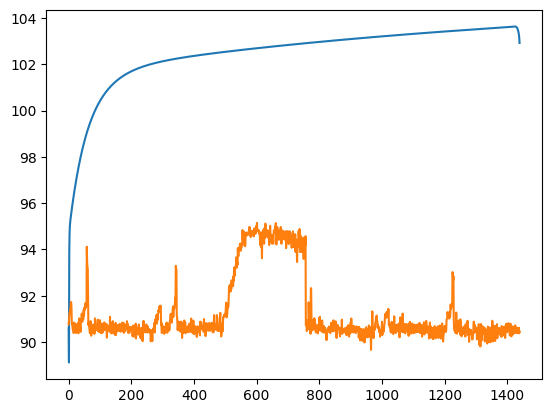

In [15]:
sns.lineplot(x=range(len(next_day_predictions)), y=next_day_predictions)
sns.lineplot(x=range(len(health_data[-1440:])), y=health_data[-1440:])

In [46]:
health_data[-1440:]

array([91.36485029, 91.37100762, 91.43046871, ..., 90.56746016,
       90.6595427 , 90.65800801])